<a href="https://colab.research.google.com/github/Elvira-Zainulina/ml_MRI_age_prediction/blob/master/3D_CNN_4_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install torchio

     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 42.5MB 72kB/s 
  Created wheel for Python-Deprecated: filename=Python_Deprecated-1.1.0-py2.py3-none-any.whl size=3069 sha256=72e640836690da73eeb423c36712a10668a7825875138e52e51ad5d999204a2b
  Stored in directory: /root/.cache/pip/wheels/b8/f1/81/2a12cf4208f219e3f023a6211a47165e74e50d534c6a3c3e64
Successfully built Python-Deprecated


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 3D CNN

In [0]:
import os
import gc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from ml_utils.data import S500MRI_Dataset_simple
from ml_utils.data import ImbalancedDatasetSampler
from ml_utils.transforms import RandomFlip
from ml_utils.train_functions import set_random_seeds
from ml_utils.train_functions import training_plot
from ml_utils.train_functions import train, test
from ml_utils.uploading import load_data
from models import S500MRI_clf
RND_STATE = 127

### Data uploading

In [0]:
#path consisting datasets that were created in the Data_preparation.ipynb
path = r"drive/My Drive/Colab Notebooks/ml-project/data"

In [0]:
X_train, y_train, g_train = load_data(os.path.join(path, 'train_dataset.npy'))
X_val, y_val, g_val = load_data(os.path.join(path, 'val_dataset.npy'))
X_test, y_test, g_test = load_data(os.path.join(path, 'test_dataset.npy'))

Define transforms for data-augmentation.

In [0]:
composed = transforms.Compose([RandomFlip(axis=0),
                               RandomFlip(axis=1),
                               RandomFlip(axis=2)])

Make the datasets.

In [0]:
train_data = S500MRI_Dataset_simple(X_train, g_train, y_train)
val_data = S500MRI_Dataset_simple(X_val, g_val, y_val)
test_data = S500MRI_Dataset_simple(X_test, g_test, y_test)

#### Model training with the best found training parameters


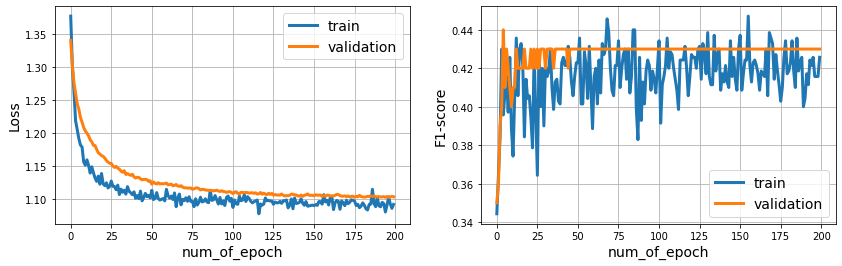

Epoch 199: train_loss 1.0914, val_loss 1.1029 	train_f1_score 0.4257, val_f1_score 0.4300 
Finished training.


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_random_seeds(seed_value=100, device=device)

net = S500MRI_clf().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.1)

train_dataloader = DataLoader(train_data, batch_size=36, shuffle=True, num_workers=4) 
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=False, num_workers=4)

(losses, losses_dev,
 f1_scores, f1_scores_dev) = train(train_dataloader, val_dataloader,
                                     net, optimizer, criterion, 200, scheduler=None,
                                     device=device, draw=True, verbose=True,
                                     output_clf=os.path.join(path, 'clf_4_s_200_wtr.pt'))

Save learning curve

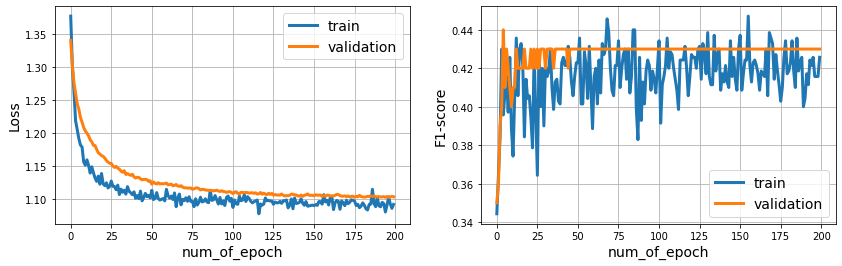

In [0]:
training_plot(losses, losses_dev, f1_scores, f1_scores_dev, 
              os.path.join(path, 'clf_4_s_200_wtr.pdf'))

Obtain scores on train, validation, test sets.

In [0]:
net = torch.load(os.path.join(path, 'clf_4_s_200_wtr.pt'))
tr_dl = DataLoader(train_data, batch_size=20, shuffle=False, num_workers=4) 
_, tr_f1 = test(tr_dl, net, criterion, device=device)
print('Train f1-score:', tr_f1)
val_dl = DataLoader(val_data, batch_size=20, shuffle=False, num_workers=4) 
_, val_f1 = test(val_dl, net, criterion, device=device)
print('Validation f1-score:', val_f1)
test_dl = DataLoader(test_data, batch_size=20, shuffle=False, num_workers=4) 
_, test_f1 = test(test_dl, net, criterion, device=device)
print('Test f1-score:', test_f1)


Train f1-score: 0.4257142857142857



Validation f1-score: 0.42999999999999994



Test f1-score: 0.494949494949495


### Experiments with other training parameters.

(Not all experiments are saved)

In [0]:
train_data = S500MRI_Dataset_simple(X_train, g_train, y_train)
val_data = S500MRI_Dataset_simple(X_val, g_val, y_val)
test_data = S500MRI_Dataset_simple(X_test, g_test, y_test)

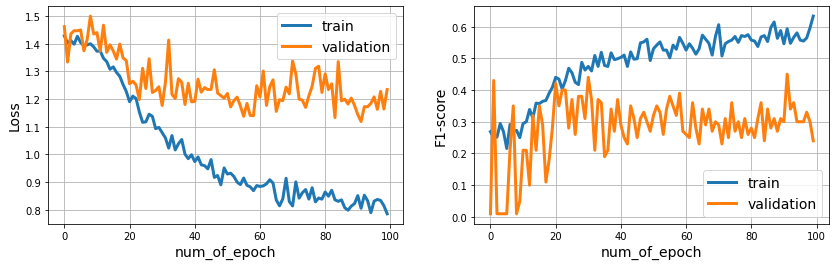

Epoch 99: train_loss 0.7861, val_loss 1.2341 	train_f1_score 0.6329, val_f1_score 0.2400 
Finished training.


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_random_seeds(seed_value=100, device=device)

net = S500MRI_clf().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=1.-1e-1)

train_dataloader = DataLoader(
    train_data, 
    sampler=ImbalancedDatasetSampler(train_data, limit_p=True),
    batch_size=20, 
    num_workers=4
)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=False, num_workers=4)

(losses, losses_dev,
 f1_scores, f1_scores_dev) = train(train_dataloader, val_dataloader,
                                   net, optimizer, criterion, 100, scheduler=None,
                                   device=device, draw=True, verbose=True,
                                   output_clf=os.path.join(path, 'clf_4_ids.pt'))

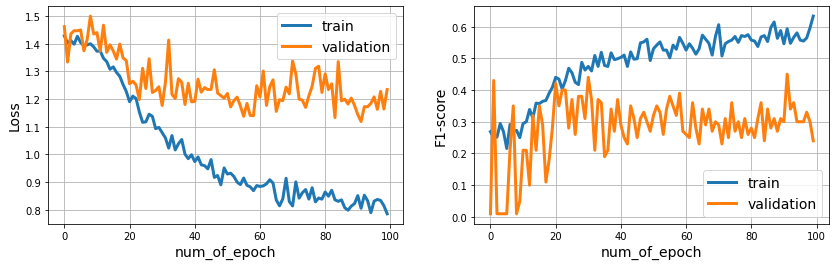

In [0]:
training_plot(losses, losses_dev, f1_scores, f1_scores_dev, 
              os.path.join(path, 'clf_4_ids.pdf'))

In [0]:
tr_dl = DataLoader(train_data, batch_size=20, shuffle=False, num_workers=4) 
_, tr_f1 = test(tr_dl, net, criterion, device=device)
print('Train f1-score:', tr_f1)
val_dl = DataLoader(val_data, batch_size=20, shuffle=False, num_workers=4) 
_, val_f1 = test(val_dl, net, criterion, device=device)
print('Validation f1-score:', val_f1)
test_dl = DataLoader(test_data, batch_size=20, shuffle=False, num_workers=4) 
_, test_f1 = test(test_dl, net, criterion, device=device)
print('Test f1-score:', test_f1)


Train f1-score: 0.3842857142857143



Validation f1-score: 0.24



Test f1-score: 0.26262626262626265


In [0]:
train_data = S500MRI_Dataset_simple(X_train, g_train, y_train, 
                                    transform=composed, group_ages=True)
val_data = S500MRI_Dataset_simple(X_val, g_val, y_val, group_ages=True)

test_data = S500MRI_Dataset_simple(X_test, g_test, y_test, group_ages=True)

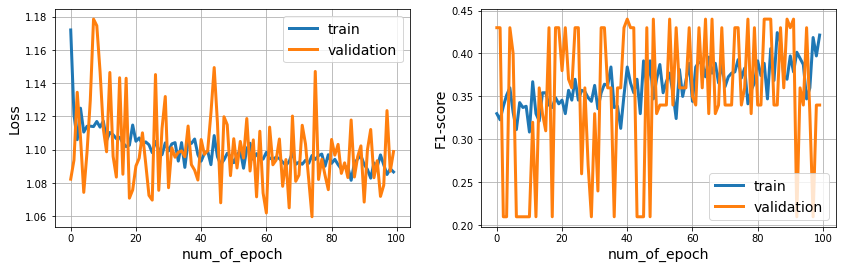

Epoch 99: train_loss 1.0867, val_loss 1.0989 	train_f1_score 0.4214, val_f1_score 0.3400 
Finished training.


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_random_seeds(seed_value=100, device=device)

net = S500MRI_clf(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=1.-1e-1)

train_dataloader = DataLoader(
    train_data, 
    sampler=ImbalancedDatasetSampler(train_data),
    batch_size=20, 
    num_workers=4
)
# train_dataloader = DataLoader(train_data, batch_size=36, shuffle=True, num_workers=4) 
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=False, num_workers=4)

(losses, losses_dev,
 f1_scores, f1_scores_dev) = train(train_dataloader, val_dataloader,
                                   net, optimizer, criterion, 100, scheduler=None,
                                   device=device, draw=True, verbose=True,
                                   output_clf=os.path.join(path, 'clf_3_ids.pt'))

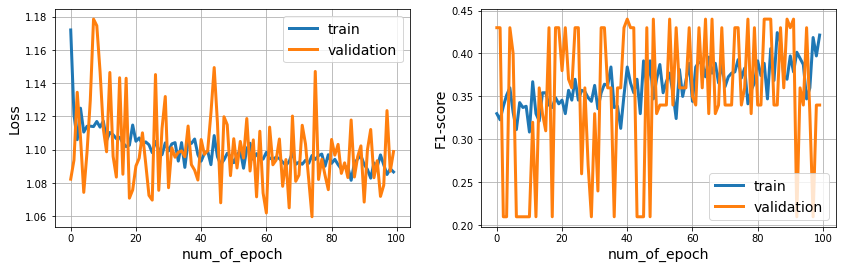

In [0]:
training_plot(losses, losses_dev, f1_scores, f1_scores_dev, 
              os.path.join(path, 'clf_3_ids.pdf'))

In [0]:
tr_dl = DataLoader(train_data, batch_size=20, shuffle=False, num_workers=4) 
_, tr_f1 = test(tr_dl, net, criterion, device=device)
print('Train f1-score:', tr_f1)
val_dl = DataLoader(val_data, batch_size=20, shuffle=False, num_workers=4) 
_, val_f1 = test(val_dl, net, criterion, device=device)
print('Validation f1-score:', val_f1)
test_dl = DataLoader(test_data, batch_size=20, shuffle=False, num_workers=4) 
_, test_f1 = test(test_dl, net, criterion, device=device)
print('Test f1-score:', test_f1)


Train f1-score: 0.37142857142857144



Validation f1-score: 0.34



Test f1-score: 0.2828282828282828
